In [9]:
import cv2
import matplotlib.pyplot as plt
from cv2.typing import *
import numpy as np
import matplotlib.patches as patches


def load_image(image_path: str):
    image = cv2.imread(image_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


def display_image(image: MatLike, title: str):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')  # Turn off the axis
    plt.show()


def quantize_image(image: MatLike, n_colors):
    Z = image.reshape((-1, 3))
    # convert to np.float32
    Z = np.float32(Z)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(
        Z, n_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    final_image = res.reshape((image.shape))

    return final_image

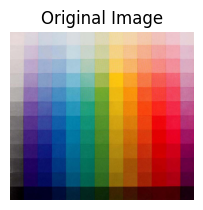

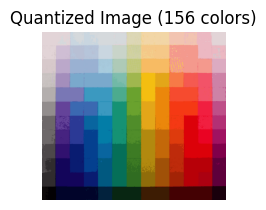

In [10]:
colors = 13*12
quantized_image = quantize_image(
    load_image(image_path="images/Ittens Colors.png"), colors)

plt.figure(1)
plt.subplot(223)
display_image(load_image(image_path="images/Ittens Colors.png"),
              'Original Image')

plt.figure(2)
plt.subplot(223)
display_image(quantized_image, f'Quantized Image ({colors} colors)')

In [12]:
def get_colors(image_array):
    colors = {}
    i = 0
    j = 0
    while i < image_array.shape[0]:
        while j < image_array.shape[1]:
            pixel = str(image_array[i, j])
            if pixel in colors:
                colors[pixel] = colors[pixel]+1
            else:
                colors[pixel] = 1
            j = j+1
        j = 0
        i = i+1
    return colors

In [13]:
def build_ittens_colors(image: MatLike):
    ittens_colors = {}
    i = 1
    j = 1
    cut = (int(image.shape[1]/12),  int(image.shape[0]/12))
    start_point = [0, cut[0]]
    while i < 13:
        ittens_colors[i] = []
        while j < 13:
            y = start_point[0]
            x = start_point[1]
            cropped_image = image[y:y+cut[0], x:x+cut[1]]
            colors = get_colors(quantize_image(cropped_image, 1)).keys()
            first_color = next(iter(colors), None)
            if first_color is not None:
                ittens_colors[i].append(first_color)
            start_point[0] = start_point[0] + cut[0]
            j += 1
        j = 1
        start_point[0] = 0
        start_point[1] = start_point[1] + cut[1]
        i += 1
    return ittens_colors

In [14]:
ittens_colors = build_ittens_colors(quantized_image)
print(ittens_colors)

{1: ['[219 210 215]', '[200 185 209]', '[177 161 198]', '[146 135 186]', '[111  99 170]', '[ 93  65 151]', '[ 74  44 135]', '[ 53  25 118]', '[27 10 98]', '[18  5 90]', '[ 4  4 52]', '[ 1  4 42]'], 2: ['[204 212 220]', '[177 189 213]', '[145 174 208]', '[119 151 196]', '[ 92 113 179]', '[ 50  83 163]', '[ 39  58 148]', '[ 20  41 128]', '[  8  30 114]', '[15 13 98]', '[ 4  4 53]', '[ 1  4 42]'], 3: ['[202 212 221]', '[176 193 216]', '[144 175 208]', '[100 163 199]', '[ 58 134 186]', '[ 34 105 168]', '[  6  83 151]', '[  4  67 144]', '[  4  65 142]', '[  7  39 120]', '[ 2 12 59]', '[ 1  7 44]'], 4: ['[211 216 220]', '[193 211 222]', '[154 193 214]', '[100 164 198]', '[ 57 152 189]', '[ 31 139 177]', '[  3 124 164]', '[  6 109 159]', '[  3  93 136]', '[  1  89 126]', '[ 2 46 74]', '[ 2 34 59]'], 5: ['[212 215 216]', '[194 209 196]', '[159 198 180]', '[103 181 159]', '[ 53 160 131]', '[ 20 145 115]', '[ 20 145 115]', '[ 11 124  98]', '[  5 111  88]', '[  5 111  87]', '[ 7 54 34]', '[ 8 38 

In [15]:
def get_color_value(ittens_colors: dict):
    for color in ittens_colors.keys():
        colors = ittens_colors.get(color)
        fig, ax = plt.subplots(1, 1, figsize=(10, 2))

        # Para cada color en la lista de colores
        for i, color in enumerate(colors):
            # Convertir el color de formato string a formato RGB
            rgb = [int(c) for c in color.strip('[]').split()]
            rgb = [c/255. for c in rgb]  # Normalizar a [0, 1]

            # Dibujar un rectángulo en el eje con el color correspondiente
            rect = patches.Rectangle((i, 0), 1, 1, facecolor=rgb)
            ax.add_patch(rect)

        # Configurar el eje
        ax.set_xlim(0, len(colors))
        ax.set_ylim(0, 1)
        ax.axis('off')  # Ocultar los ejes

        plt.show()

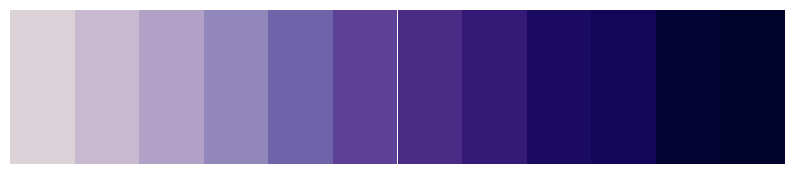

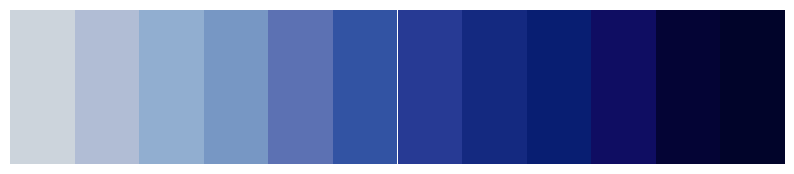

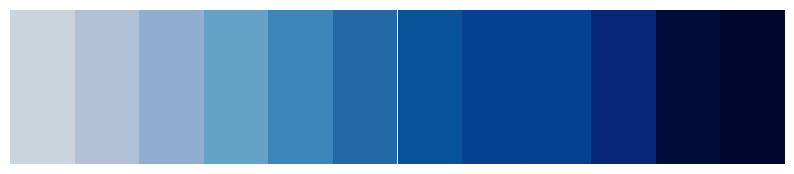

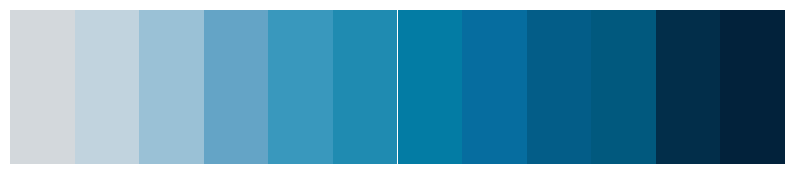

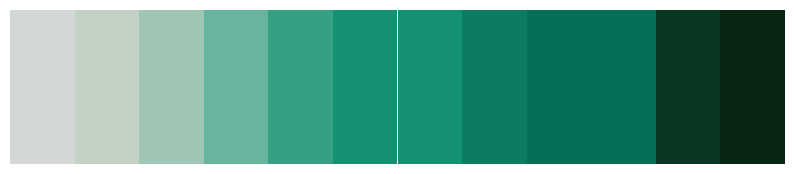

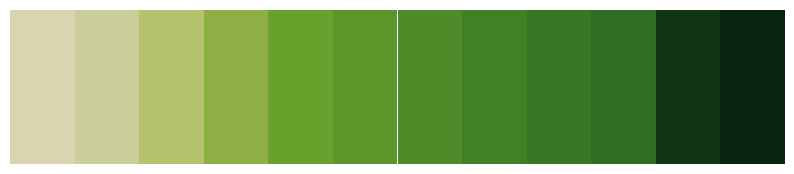

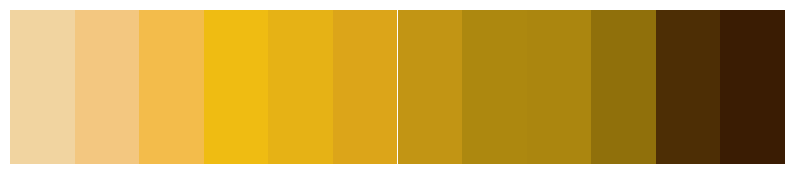

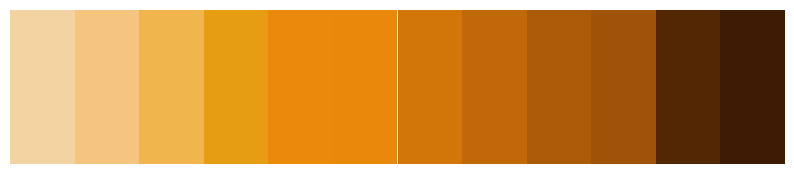

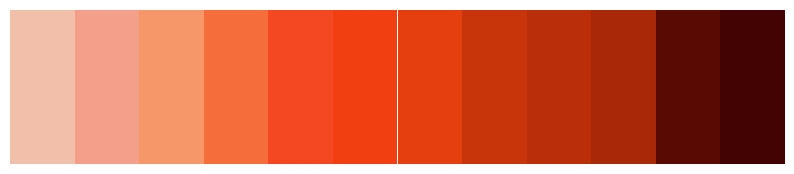

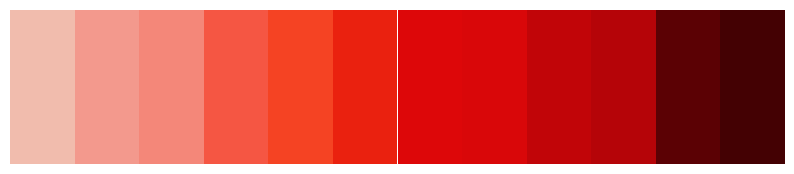

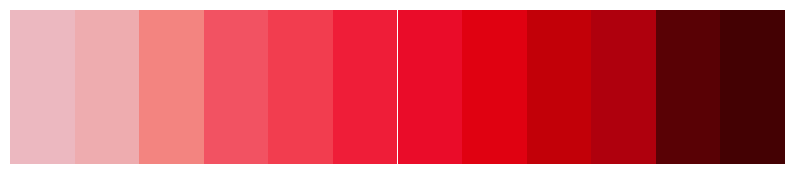

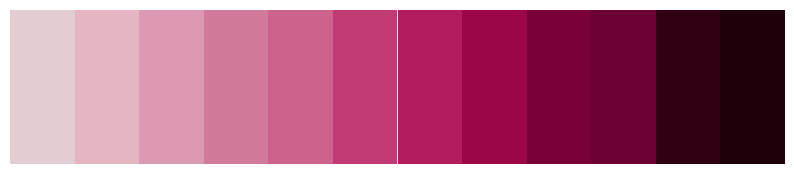

In [16]:
get_color_value(ittens_colors)